# Contribution Analysis
In this notebook, I will examine the contributions calculated by LRP. There are two kinds of different contribution scores to every gene:
* A feature contribution that tells us how important each of the features were for the classification of that gene as being a cancer gene
* A neighbor contribution that tells us which of its interacting partners in the PPI were most important for the classification of that gene

There are several strategies to make use of the LRP contributions and I would like to examine a few of them here.

In [5]:
# data science & classics
import pandas as pd
import numpy as np
import h5py
import networkx as nx
import os, sys
import subprocess

# clustering & embedding
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster import hierarchy
import umap

# other modules of mine
import gcnIO, postprocessing, utils
sys.path.append(os.path.abspath('../pancancer/preprocessing'))
import preprocessing_utils as pre_utils

import sharepathway as sp

# plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.rc('font', family='Arial')
%matplotlib inline

In [6]:
def get_hhotnet_results():
    all_clusters = []
    all_genes = []
    with open('../../hierarchical-hotnet/examples/results/clusters_mynetwork.tsv', 'r') as f:
        for line in f.readlines():
            if not line.startswith('#'): # exclude comments
                cluster = [i.strip() for i in line.split('\t')]
                if len(cluster) == 1:
                    break
                all_clusters.append(cluster)
                all_genes += cluster
    return all_clusters, all_genes


def get_cancer_genes():
    # get the NCG cancer genes
    known_cancer_genes = []
    candidate_cancer_genes = []
    n = 0
    with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
        for line in f.readlines():
            n += 1
            if n == 1:
                continue
            l = line.strip().split('\t')
            if len(l) == 2:
                known_cancer_genes.append(l[0])
                candidate_cancer_genes.append(l[1])
            else:
                candidate_cancer_genes.append(l[0])

    oncokb_genes = pd.read_csv('../data/pancancer/oncoKB/cancerGeneList.txt', sep='\t')
    return oncokb_genes, known_cancer_genes, candidate_cancer_genes


def plot_rolling_avg(ax, data, window_size=200):
    rolling_avg = data.rolling(window=window_size).median()
    sns.lineplot(x=range(data.shape[0]), y=rolling_avg)
    plt.fill_between(range(data.shape[0]), rolling_avg)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


def get_pathway_enrichment(genes, cluster_idx, out_dir):
    # write cluster information to disk
    genes.set_index('ID').to_csv(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)), sep='\t')
    # formulate command to hand to R script
    cmd = 'Rscript KEGG.R {} {} {}'.format(os.path.join(out_dir, 'cluster_{}.tsv'.format(cluster_idx)),
                                           os.path.join(out_dir, 'cluster_{}_pathways.txt'.format(cluster_idx)),
                                           genes.shape[0]
                                          )
    res = subprocess.call(cmd, shell=True)
    # read pathways and return
    top_pathways = pd.read_csv(os.path.join(model_dir, 'cluster_{}_pathways.txt'.format(cluster_number)),
                               sep='\t')[['Pvalue', 'Count', 'Size', 'Term']].head(5)
    return top_pathways


def plot_representative(ax, rep, rep_std, xlabels, title=None):
    ax.bar(x=np.arange(len(xlabels)), height=rep.values, tick_label=xlabels)#, yerr=rep_std.values)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    if not title is None:
        ax.set_title(title, fontsize=16)
    ax.set_ylabel('Feature Contribution')
    utils.colorize_by_omics(ax, xlabels)


def plot_representative_heatmap(ax, rep, xlabels, title=None):
    rep = rep.reshape(16, 3, order='F')
    inner = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0, subplot_spec=ax)
    omics = ['Mutation', 'Methylation', 'Expression']
    cmaps = [sns.color_palette("Reds"), sns.color_palette("Blues"), sns.color_palette("Greens")]
    vmax = x.max()
    vmin = x.min()
    print ("Max and min ", vmax, vmin)
    for c in range(3):
        ax = plt.Subplot(fig, inner[c])
        xticklabels = False
        if c == 2:
            xticklabels = [i.split(':')[1] for i in xlabels[:16]]
        sns.heatmap(rep[:, c].reshape(1, -1), ax=ax, xticklabels=xticklabels,
                    cbar=False, cmap=cmaps[c],
                    cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
                    vmax=vmax, vmin=vmin)
        ax.set_yticklabels([omics[c]], rotation=0, fontsize=10)
        if not title is None and c == 0:
            ax.set_title(title, fontsize=16)
        fig.add_subplot(ax)
    plt.subplots_adjust(bottom=0.05, hspace=0.05, wspace=0)


def plot_pathway_information(ax, pathways):
    for i in range(pathways.shape[0]):
        ax.text(0, 0.9-i*0.2, '{0}  {1:.2f}  {2}  {3}  {4}'.format(i, pathways.iloc[i]['Pvalue'],
                                                                   pathways.iloc[i]['Count'],
                                                                   pathways.iloc[i]['Size'],
                                                                   pathways.iloc[i]['Term']
                                                                  )
               )
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

## Load the Clustering Results

In [7]:
"""model_dir = '../data/GCN/training/2019_03_06_15_45_33/'
with h5py.File(os.path.join(model_dir, 'contributions_allgenes.h5'), 'r') as f:
    lrp_neighbor_matrix = f['neighbor_contribution'][:]
    lrp_feature_matrix = f['feature_contribution'][:]
    node_names = f['gene_names'][:]
    feature_names = f['feature_names'][:]
    print (lrp_neighbor_matrix.shape, lrp_feature_matrix.shape, node_names.shape, feature_names.shape)

args, _ = gcnIO.load_hyper_params(model_dir)
with h5py.File(args['data'], 'r') as f:
    node_names = f['gene_names'][:]
"""

model_dir = '../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/'
args, _ = gcnIO.load_hyper_params(model_dir)
with h5py.File(args['data'], 'r') as f:
    node_names = f['gene_names'][:]
    feature_names = f['feature_names'][:]
    adjacency = f['network'][:]
feature_contributions = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'feat_mean_all.npy'))
# replace 0 values with small random ones to prevent numerical issues
feat_contrib_df = pd.DataFrame(feature_contributions, index=node_names[:feature_contributions.shape[0], 1], columns=feature_names)
zero_rows = feat_contrib_df[(feat_contrib_df == 0).all(axis=1)]
feat_contrib_df.loc[(feat_contrib_df == 0).all(axis=1)] = np.random.randn(*zero_rows.shape)*0.00001
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])

In [8]:
pred = postprocessing.load_predictions(model_dir)

In [9]:
(feat_contrib_df == 0).all(axis=1).sum()

0

## Heatmap to visualize clusters of important features

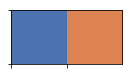

In [6]:
# compute the linkage matrix prior to the seaborn clustermap
Z = hierarchy.linkage(feat_contrib_df, method='average', metric='correlation')
# compute flat clusters from that
flat_clusters = hierarchy.cut_tree(Z, n_clusters=2)
flat_clusters_series = pd.Series(flat_clusters.reshape(-1))
# map flat clusters to colors for plotting in the heatmap
lut_flatclu = dict(zip(flat_clusters_series.unique(), sns.color_palette("deep", n_colors=flat_clusters_series.nunique())))
flat_rowcols = flat_clusters_series.map(lut_flatclu)
sns.palplot(lut_flatclu.values())

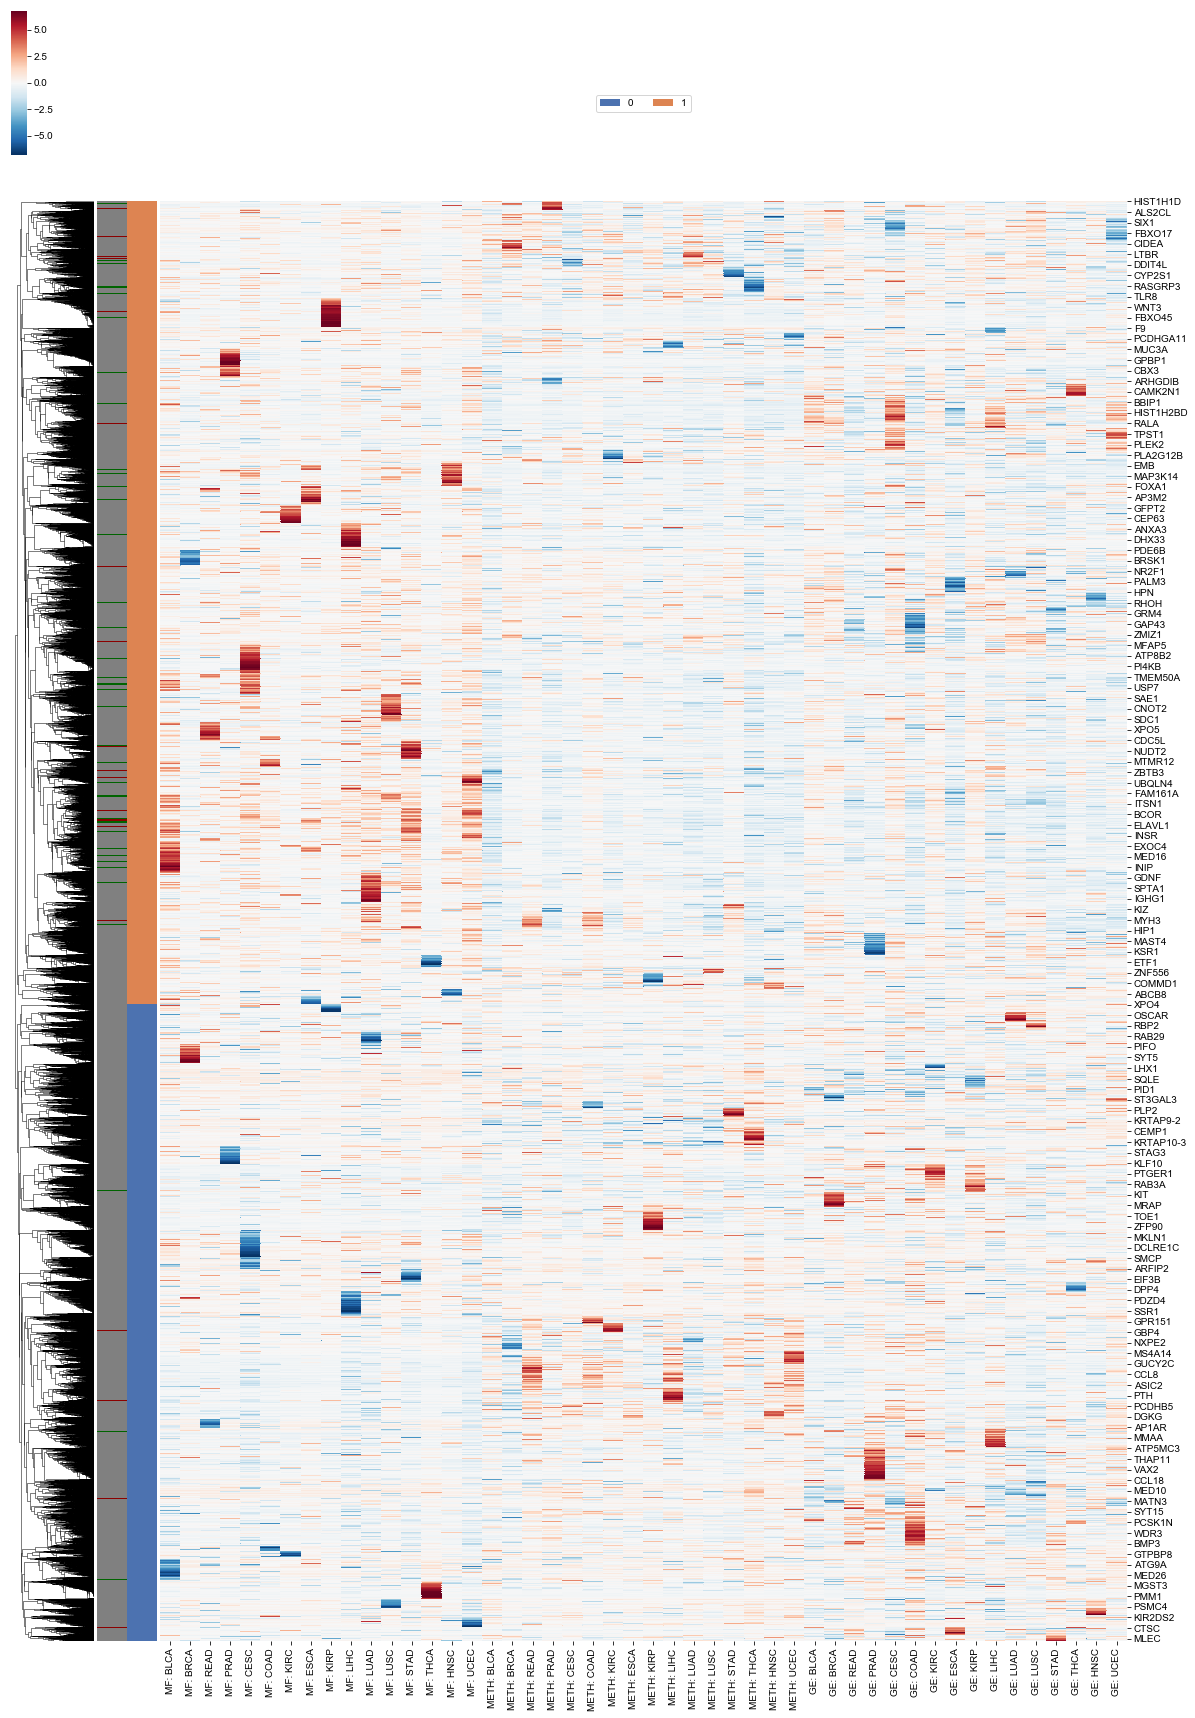

In [7]:
sys.setrecursionlimit(10000)

# get the literature information on known cancer genes
"""
oncokb, known, candidate = get_cancer_genes()
arr = np.zeros(feat_contrib_df.shape[0])
arr[feat_contrib_df.index.isin(known)] = 1
arr[feat_contrib_df.index.isin(candidate)] = 2
#arr[feat_contrib_df.index.isin(oncokb['Hugo Symbol'])] = 3
df = pd.Series(arr, index=feat_contrib_df.index, name='Literature Knowledge')
"""
cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv').set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(feat_contrib_df.shape[0])
onco_tsg_annotation[feat_contrib_df.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[feat_contrib_df.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=feat_contrib_df.index, name='CancerGeneCensus')

lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
row_colors = onco_tsg_annotation.map(lut)

# perform the clustering
clu = sns.clustermap(feat_contrib_df,
                     #row_linkage=Z,
                     z_score=0, # axis 0
                     metric='correlation',
                     figsize=(20, 30),
                     col_cluster=False,
                     yticklabels=100,
                     row_colors=[row_colors, flat_rowcols],
                     cmap="RdBu_r"
                    )
# put in a fake legend that shows clusters
for c in flat_clusters_series.unique():
    clu.ax_col_dendrogram.bar(0, 0, color=lut_flatclu[c],
                            label=c, linewidth=0)
clu.ax_col_dendrogram.legend(loc="center", ncol=6)
#clu.savefig(os.path.join(model_dir, 'clustering_lrp.png'), dpi=300)

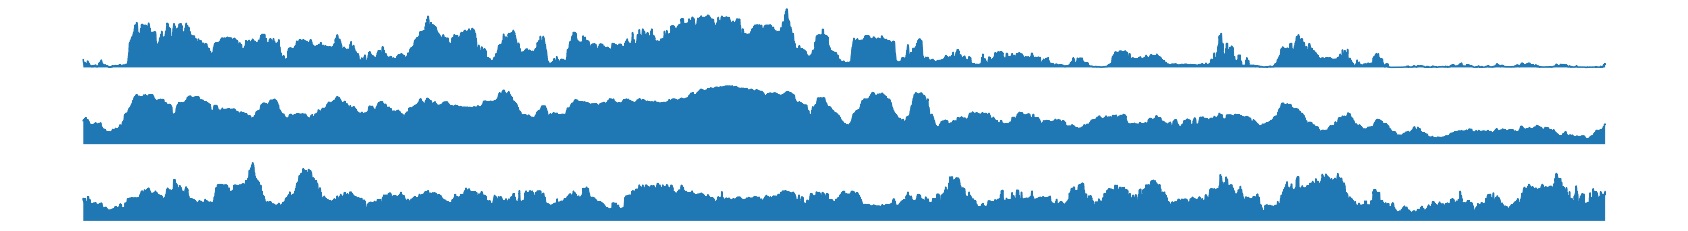

In [144]:
feature_contribution_sum = pd.Series(feat_contrib_df.sum(axis=1), name='Feature_Sum')
feat_contrib_predictions = pred.join(feature_contribution_sum, on='Name')
feat_contrib_predictions['Diff'] = feat_contrib_predictions.Feature_Sum / (feat_contrib_predictions.Prob_pos + 0.0001)
feat_contrib_predictions['Idx_Num'] = range(feat_contrib_predictions.shape[0])

feature_contribs_dendroindex = feat_contrib_predictions.set_index('Idx_Num').loc[clu.dendrogram_row.reordered_ind, 'Feature_Sum']
predictions_dendroindex = feat_contrib_predictions.set_index('Idx_Num').loc[clu.dendrogram_row.reordered_ind, 'Prob_pos']
diff_dendroindex = feat_contrib_predictions.set_index('Idx_Num').loc[clu.dendrogram_row.reordered_ind, 'Diff']




fig = plt.figure(figsize=(30, 4))
ax = plt.subplot(3, 1, 1)
plot_rolling_avg(ax, feature_contribs_dendroindex)
ax = plt.subplot(3, 1, 2)
plot_rolling_avg(ax, predictions_dendroindex)
ax = plt.subplot(3, 1, 3)
plot_rolling_avg(ax, diff_dendroindex)
#fig.savefig(os.path.join(model_dir, 'feature_contribution_density.png'), dpi=300)

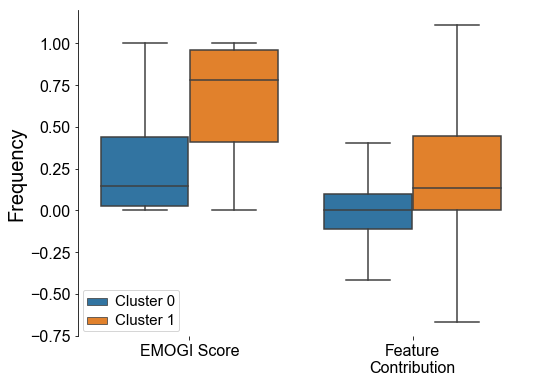

In [145]:
n_clusters_boxplots = 2
feat_vs_node = hierarchy.cut_tree(clu.dendrogram_row.linkage, n_clusters=n_clusters_boxplots) # the first cluster are mutation driven, the second not

cluster_label_list = ['Cluster {}'.format(i) for i in range(n_clusters_boxplots)]

feat_vs_node_series = pd.Series(feat_vs_node.reshape(-1))
nodes_with_cluster = nodes.copy()
nodes_with_cluster['Cluster'] = feat_vs_node
nodes_cluster_pred = nodes_with_cluster.join(pred.drop('Name', axis=1), on='ID').set_index('Name')
nodes_enriched = nodes_cluster_pred.join(feat_contrib_df.sum(axis=1).rename('Feature_Contribution'))
nodes_enriched.loc[nodes_enriched.label.isnull(), 'label'] = 0
nodes_enriched.loc[nodes_enriched.label == True, 'label'] = 1
nodes_enriched.loc[nodes_enriched.label == False, 'label'] = 0

fig = plt.figure(figsize=(8, 6))
g = sns.boxplot(data=pd.melt(nodes_enriched.drop(['label', 'Std_Pred', 'Num_Pos'], axis=1), id_vars=['ID', 'Cluster']),
            x='variable', y='value', hue='Cluster', showfliers=False)
plt.xlabel(None)
plt.ylabel('Frequency', fontsize=20)
for t, l in zip(g.legend().texts, cluster_label_list):
    t.set_text(l)
    t.set_size(15)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#plt.gca().get_xaxis().set_visible(False)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(['EMOGI Score', 'Feature\nContribution'])
fig.savefig(os.path.join(model_dir, '{}_clusters_difference.svg'.format(n_clusters_boxplots)))

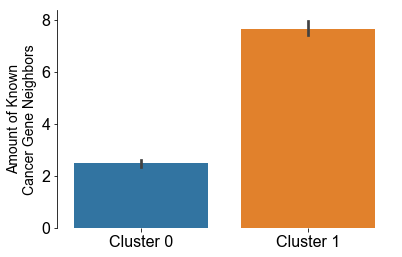

In [149]:
fig = plt.figure(figsize=(6, 4))
A = pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1])
num_known_neighbors = A[A.index.isin(pred[pred.label == True].Name)].sum(axis=0).rename('Num_Cancer_Gene_Neighbors')
sns.barplot(data=nodes_enriched.join(num_known_neighbors)[['Cluster', 'Num_Cancer_Gene_Neighbors']], x='Cluster', y='Num_Cancer_Gene_Neighbors')
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(cluster_label_list)
plt.ylabel('Amount of Known\nCancer Gene Neighbors', fontsize=14)
plt.xlabel(None)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
fig.savefig(os.path.join(model_dir, '{}_clusters_cancerneighbors.svg'.format(n_clusters_boxplots)))

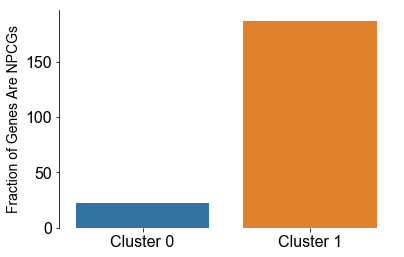

In [158]:
fig = plt.figure(figsize=(6, 4))
npcgs = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
npcgs.set_index('Name', inplace=True)
nodes_enriched['NPCG'] = 0
nodes_enriched.loc[nodes_enriched.index.isin(npcgs.index), 'NPCG'] = 1
npcgs_cl = [nodes_enriched[nodes_enriched.Cluster == i].NPCG.sum() for i in range(n_clusters_boxplots)]
sns.barplot(x=cluster_label_list, y=npcgs_cl)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(cluster_label_list)
plt.ylabel('Fraction of Genes Are NPCGs', fontsize=14)
plt.xlabel(None)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
fig.savefig(os.path.join(model_dir, '{}_clusters_npcgs.svg'.format(n_clusters_boxplots)))

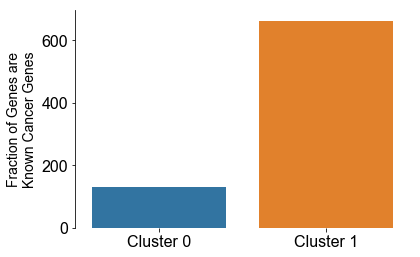

In [159]:
fig = plt.figure(figsize=(6, 4))
cgs = [nodes_enriched[nodes_enriched.Cluster == i].label.sum() for i in range(n_clusters_boxplots)]
#sns.barplot(data=nodes_enriched[['Cluster', 'label']], x='Cluster', y='label')
sns.barplot(x=cluster_label_list, y=cgs)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels(cluster_label_list)
plt.ylabel('Fraction of Genes are\nKnown Cancer Genes', fontsize=14)
plt.xlabel(None)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
fig.savefig(os.path.join(model_dir, '{}_clusters_literature.svg'.format(n_clusters_boxplots)))

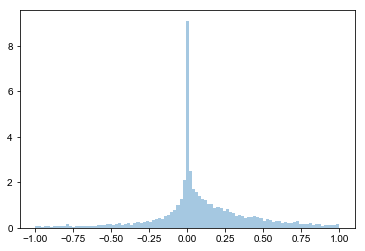

In [106]:
bins = np.linspace(-1, 1, 100)
sns.distplot(feat_contrib_df.sum(axis=1), bins=bins, kde=False, hist_kws={'density': True})
#plt.xlim([-10, 10])

## Compute Cluster Representatives and Pathway Enrichment

In [160]:
cluster_pathway_information = []
for cluster_number in flat_clusters_series.unique():
    cluster_gene_indices = flat_clusters_series[flat_clusters_series == cluster_number].index
    cluster_genes = nodes[nodes.Name.isin(feat_contrib_df.iloc[cluster_gene_indices].index)]
    #cluster_genes = nodes_highfeat[nodes_highfeat.index.isin(cluster_gene_indices)]
    #print ("Cluster {} contains {} genes".format(cluster_number, cluster_genes.shape[0]))
    top_pathways = get_pathway_enrichment(cluster_genes, cluster_number, model_dir)
    cluster_pathway_information.append((cluster_number, top_pathways))

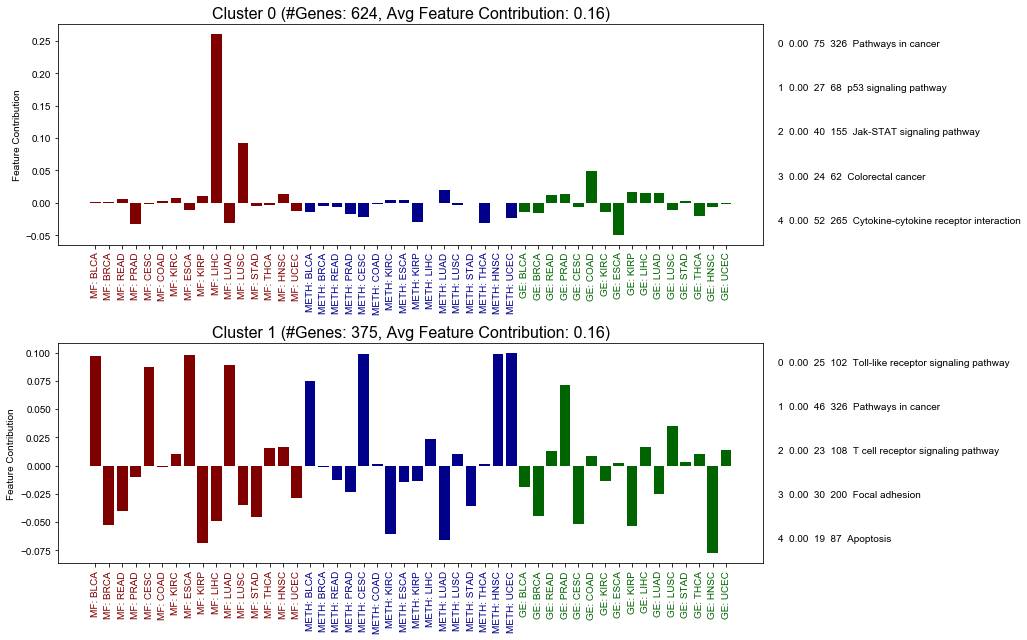

In [161]:
sum_of_all = 0
n_clusters = flat_clusters_series.nunique()
fig, axes = plt.subplots(nrows=n_clusters, ncols=2,
                         figsize=(15, n_clusters*3 + 3),
                         gridspec_kw={'width_ratios': [3, 1]}
                        )


for cluster_number in flat_clusters_series.unique():
    # find the genes in the current cluster
    cluster_gene_indices = flat_clusters_series[flat_clusters_series == cluster_number].index
    cluster_genes = nodes[nodes.Name.isin(feat_contrib_df.iloc[cluster_gene_indices].index)]
    
    # compute the representative for that cluster
    features_of_cluster = feat_contrib_df.iloc[cluster_gene_indices]
    representative = features_of_cluster.mean(axis=0)
    representative_std = features_of_cluster.std(axis=0)
    # plot barplot for representative
    plot_representative(axes[cluster_number][0], representative, representative_std, representative.index,
                        title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(cluster_number,
                                                                                                    cluster_genes.shape[0],
                                                                                                    representative.sum()
                                                                                                   )
                       )
    # plot the pathways next to it
    plot_pathway_information(axes[cluster_number][1], cluster_pathway_information[cluster_number][1])
plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'cluster_representatives_{}.pdf'.format(flat_clusters_series.nunique())))

## Repeat Clustering for Feature-Driven Genes

In [51]:
pred.head()

,Name,label,Num_Pos,Prob_pos,Std_Pred
ID,,,,,
ENSG00000284792,PTEN,True,10,1.000,0.000
ENSG00000136997,MYC,True,10,1.000,0.000
ENSG00000141646,SMAD4,True,10,1.000,0.000
ENSG00000141510,TP53,True,10,1.000,0.000
ENSG00000146648,EGFR,True,10,1.000,0.000


Selected 999 Genes again for Hierarchical Clustering


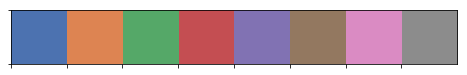

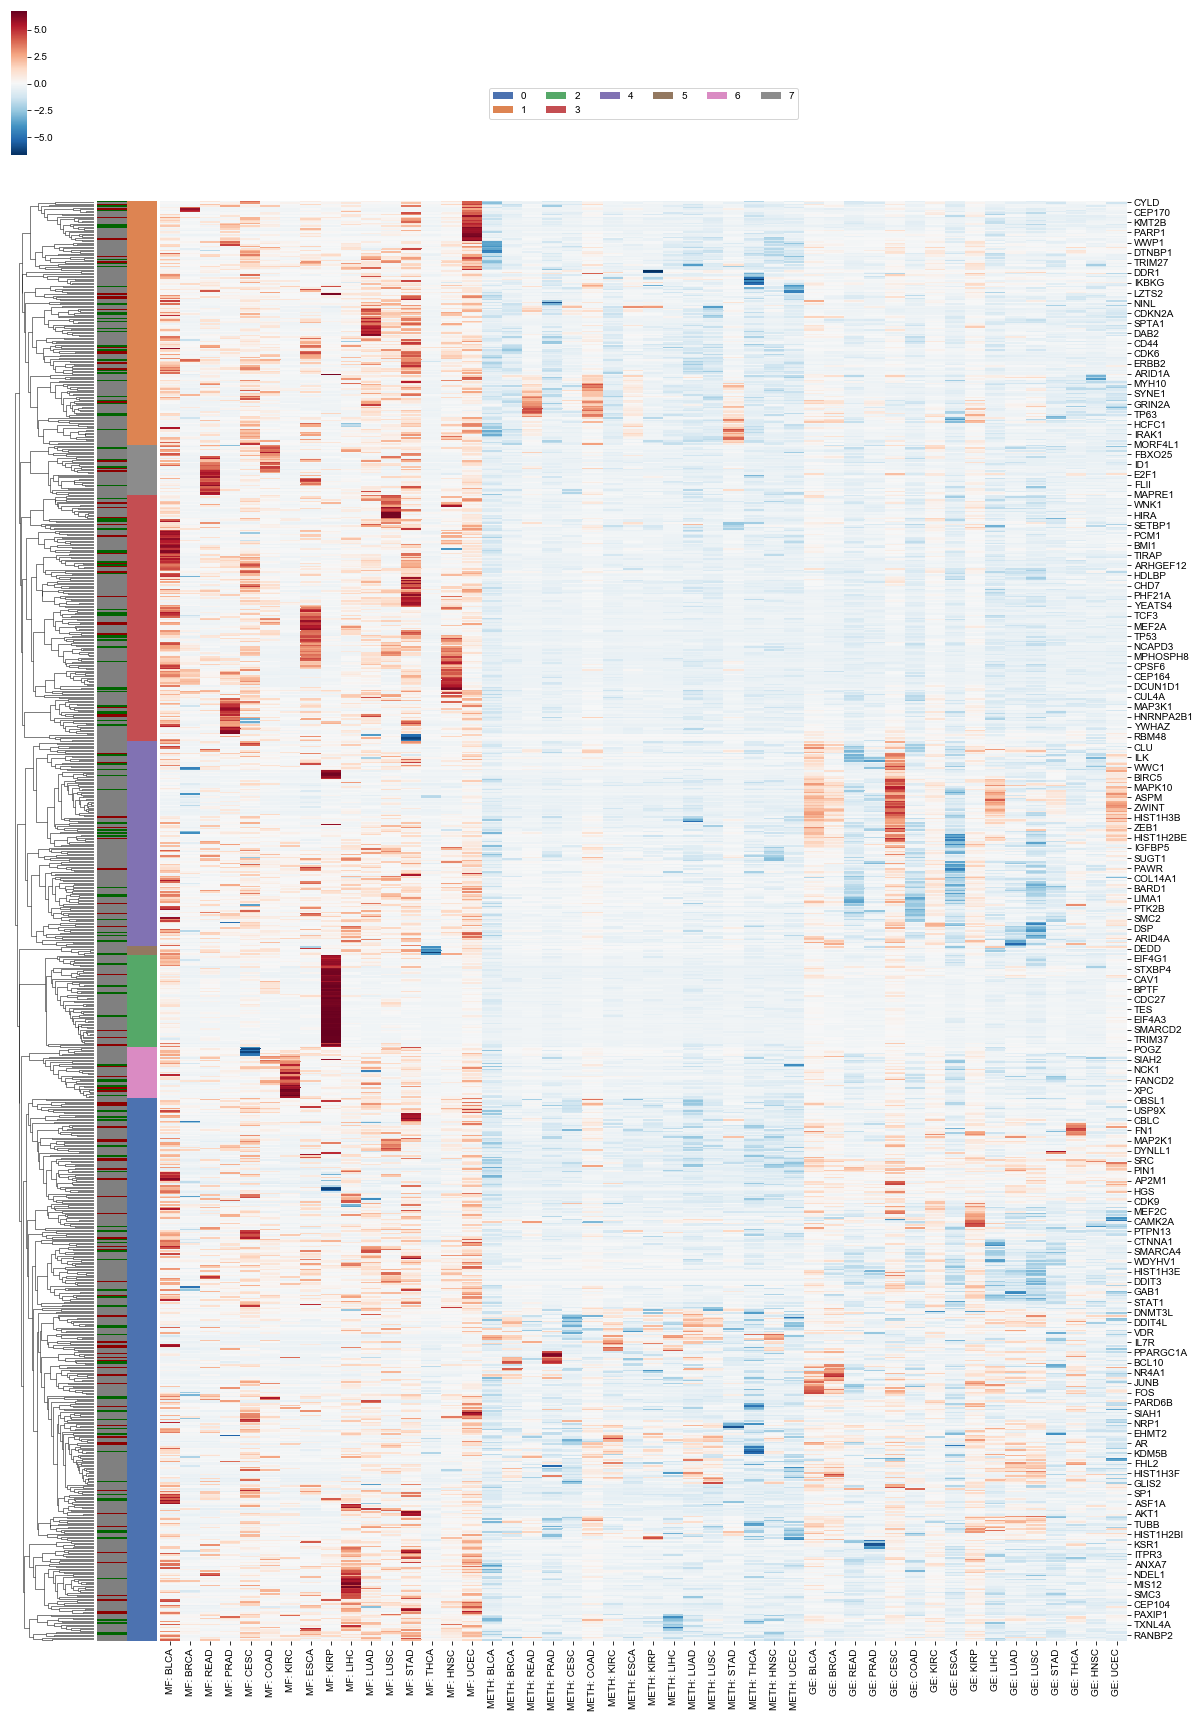

In [28]:
high_feat_contrib = feat_contrib_df[feat_contrib_df.index.isin(pred.head(1000).Name)]
#high_feat_contrib = feat_contrib_df[feat_contrib_df.index.isin(pred[pred.Prob_pos > 0.95].Name)]
high_feat_contrib = high_feat_contrib[high_feat_contrib.sum(axis=1).between(-1, 1)]
print ("Selected {} Genes again for Hierarchical Clustering".format(high_feat_contrib.shape[0]))

# compute the linkage matrix prior to the seaborn clustermap
from sklearn import preprocessing
Z_highconf = hierarchy.linkage(preprocessing.StandardScaler().fit_transform(high_feat_contrib), method='average', metric='correlation')
# compute flat clusters from that
flat_clusters = hierarchy.cut_tree(Z_highconf, n_clusters=8)
flat_clusters_series = pd.Series(flat_clusters.reshape(-1))
# map flat clusters to colors for plotting in the heatmap
lut_flatclu = dict(zip(flat_clusters_series.unique(),
                       sns.color_palette("deep", n_colors=flat_clusters_series.nunique())))
flat_rowcols_highconf = flat_clusters_series.map(lut_flatclu)
sns.palplot(lut_flatclu.values())

# get the literature information on known cancer genes
cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv').set_index('Gene Symbol')
onco_tsg_annotation = np.zeros(high_feat_contrib.shape[0])
onco_tsg_annotation[high_feat_contrib.index.isin(cgc[cgc['Role in Cancer'].str.contains('oncogene') == True].index)] = 1
onco_tsg_annotation[high_feat_contrib.index.isin(cgc[cgc['Role in Cancer'].str.contains('TSG') == True].index)] = 2
onco_tsg_annotation = pd.Series(onco_tsg_annotation, index=high_feat_contrib.index, name='CancerGeneCensus')

lut = dict(zip(onco_tsg_annotation.unique(), ['grey', 'darkred', 'darkgreen']))
row_colors = onco_tsg_annotation.map(lut)

# perform the clustering
clu = sns.clustermap(high_feat_contrib,
                     row_linkage=Z_highconf,
                     z_score=0, # axis 0
                     #standard_scale=0,
                     metric='euclidean',
                     figsize=(20, 30),
                     col_cluster=False,
                     yticklabels=7,
                     row_colors=[row_colors, flat_rowcols_highconf],
                     #robust=True,
                     cmap="RdBu_r"
                    )

# plot the cluster indices as legend
for c in flat_clusters_series.unique():
    clu.ax_col_dendrogram.bar(0, 0, color=lut_flatclu[c],
                            label=c, linewidth=0)
clu.ax_col_dendrogram.legend(loc="center", ncol=6)

#clu.savefig(os.path.join(model_dir, 'clustering_lrp_highconf.png'), dpi=300)

In [25]:
test = pd.DataFrame(preprocessing.StandardScaler().fit_transform(high_feat_contrib), index=high_feat_contrib.index, columns=high_feat_contrib.columns)

clu.data2d.max().max()

6.758872500600917

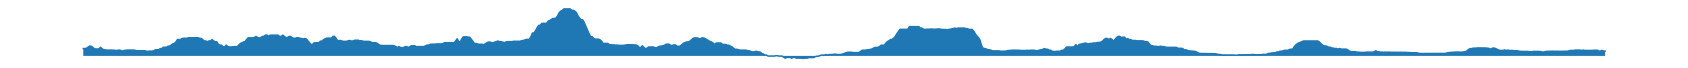

In [79]:
feature_contribution_sum = pd.Series(high_feat_contrib.sum(axis=1), name='Feature_Sum')
feature_contribs_dendroindex = feature_contribution_sum[clu.dendrogram_row.reordered_ind]

fig = plt.figure(figsize=(30, 1))
ax = plt.subplot(1, 1, 1)
plot_rolling_avg(ax, feature_contribs_dendroindex, window_size=30)
fig.savefig(os.path.join(model_dir, 'feature_contribution_density_highconf.png'), dpi=300)

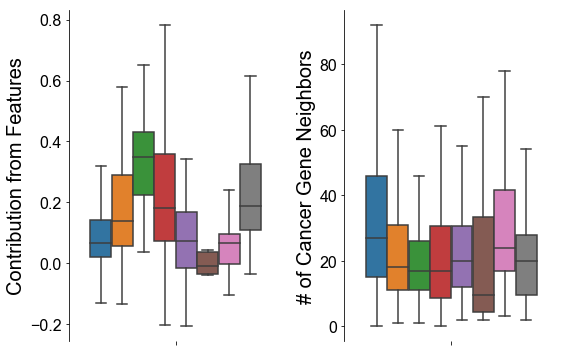

In [58]:
n_clusters_boxplots = 8
clusters = hierarchy.cut_tree(clu.dendrogram_row.linkage, n_clusters=n_clusters_boxplots)

cluster_label_list = ['Cluster {}'.format(i) for i in range(n_clusters_boxplots)]

nodes_highconf = pd.DataFrame(high_feat_contrib.index.copy(), columns=['Name']).set_index('Name')
nodes_highconf['Cluster'] = clusters

# put in the amount of feature contribution
nodes_highconf_pred = nodes_highconf.join(pred.set_index('Name'))
nodes_enriched = nodes_highconf_pred.join(high_feat_contrib.sum(axis=1).rename('Feature_Contribution'))

# put in the labels (known cancer genes)
nodes_enriched.loc[nodes_enriched.label.isnull(), 'label'] = 0
nodes_enriched.loc[nodes_enriched.label == True, 'label'] = 1
nodes_enriched.loc[nodes_enriched.label == False, 'label'] = 0

# put in number of cancer neighbors
A = pd.DataFrame(adjacency, index=node_names[:, 1], columns=node_names[:, 1])
num_known_neighbors = A[A.index.isin(pred[pred.label == True].Name)].sum(axis=0).rename('Num_Cancer_Gene_Neighbors')
nodes_enriched = nodes_enriched.join(num_known_neighbors)

# put in the number of NPCGs per cluster
npcgs = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
npcgs.set_index('Name', inplace=True)
nodes_enriched['NPCG'] = 0
nodes_enriched.loc[nodes_enriched.index.isin(npcgs.index), 'NPCG'] = 1
npcgs_cl = [nodes_enriched[nodes_enriched.Cluster == i].NPCG.sum() for i in range(n_clusters_boxplots)]

# plot
fig = plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)

# start with boxplot of feature contributions
g = sns.boxplot(data=pd.melt(nodes_enriched[['Feature_Contribution', 'Cluster']], id_vars=['Cluster']),
            x='variable', y='value', hue='Cluster', showfliers=False)
g.legend().remove()
plt.xlabel(None)
plt.ylabel('Contribution from Features', fontsize=20)
#for t, l in zip(g.legend().texts, cluster_label_list):
#    t.set_text(l)
#    t.set_size(15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#plt.gca().get_xaxis().set_visible(False)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels([])

# next, plot the number of known cancer gene neighbors
plt.subplot(1, 2, 2)
g = sns.boxplot(data=pd.melt(nodes_enriched[['Cluster', 'Num_Cancer_Gene_Neighbors']], id_vars='Cluster'),
            x='variable', y='value', hue='Cluster', showfliers=False)
g.legend().remove()
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels([])
plt.ylabel('# of Cancer Gene Neighbors', fontsize=20)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'cluster_stats_{}_boxplots.svg').format(n_clusters_boxplots))

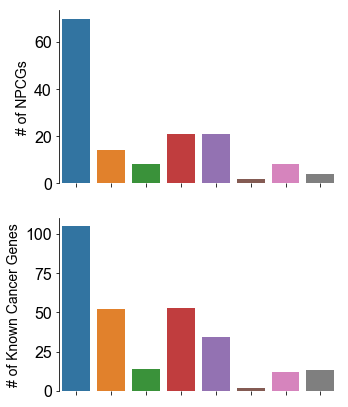

In [50]:
fig = plt.figure(figsize=(5, 7))

# next, the number of NPCGs per cluster
plt.subplot(2, 1, 1)
sns.barplot(x=cluster_label_list, y=npcgs_cl)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels([])
plt.ylabel('# of NPCGs', fontsize=14)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# next, the number of known cancer genes per cluster
plt.subplot(2, 1, 2)
cgs = [nodes_enriched[nodes_enriched.Cluster == i].label.sum() for i in range(n_clusters_boxplots)]
#sns.barplot(data=nodes_enriched[['Cluster', 'label']], x='Cluster', y='label')
sns.barplot(x=cluster_label_list, y=cgs)
plt.gca().tick_params(axis='both', labelsize=16)
plt.gca().set_xticklabels([])
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.ylabel('# of Known Cancer Genes', fontsize=14)
fig.savefig(os.path.join(model_dir, 'cluster_stats_{}_barplots.svg'.format(n_clusters_boxplots)))

In [80]:
cluster_pathways_highconf = []
for cluster_number in flat_clusters_series.unique():
    cluster_gene_indices = flat_clusters_series[flat_clusters_series == cluster_number].index
    cluster_genes = nodes[nodes.Name.isin(high_feat_contrib.iloc[cluster_gene_indices].index)]
    #cluster_genes = nodes_highfeat[nodes_highfeat.index.isin(cluster_gene_indices)]
    #print ("Cluster {} contains {} genes".format(cluster_number, cluster_genes.shape[0]))
    top_pathways = get_pathway_enrichment(cluster_genes, cluster_number, model_dir)
    cluster_pathways_highconf.append((cluster_number, top_pathways))

In [102]:
pd.reset_option('display.float_format')
cluster_pathways_highconf[4][1]

,Pvalue,Count,Size,Term
1,2.046324e-19,22,124,Cell cycle
2,1.966939e-10,14,112,Oocyte meiosis
3,1.913606e-07,10,86,Progesterone-mediated oocyte maturation
4,2.642778e-07,9,68,p53 signaling pathway
5,7.462776e-06,6,36,DNA replication


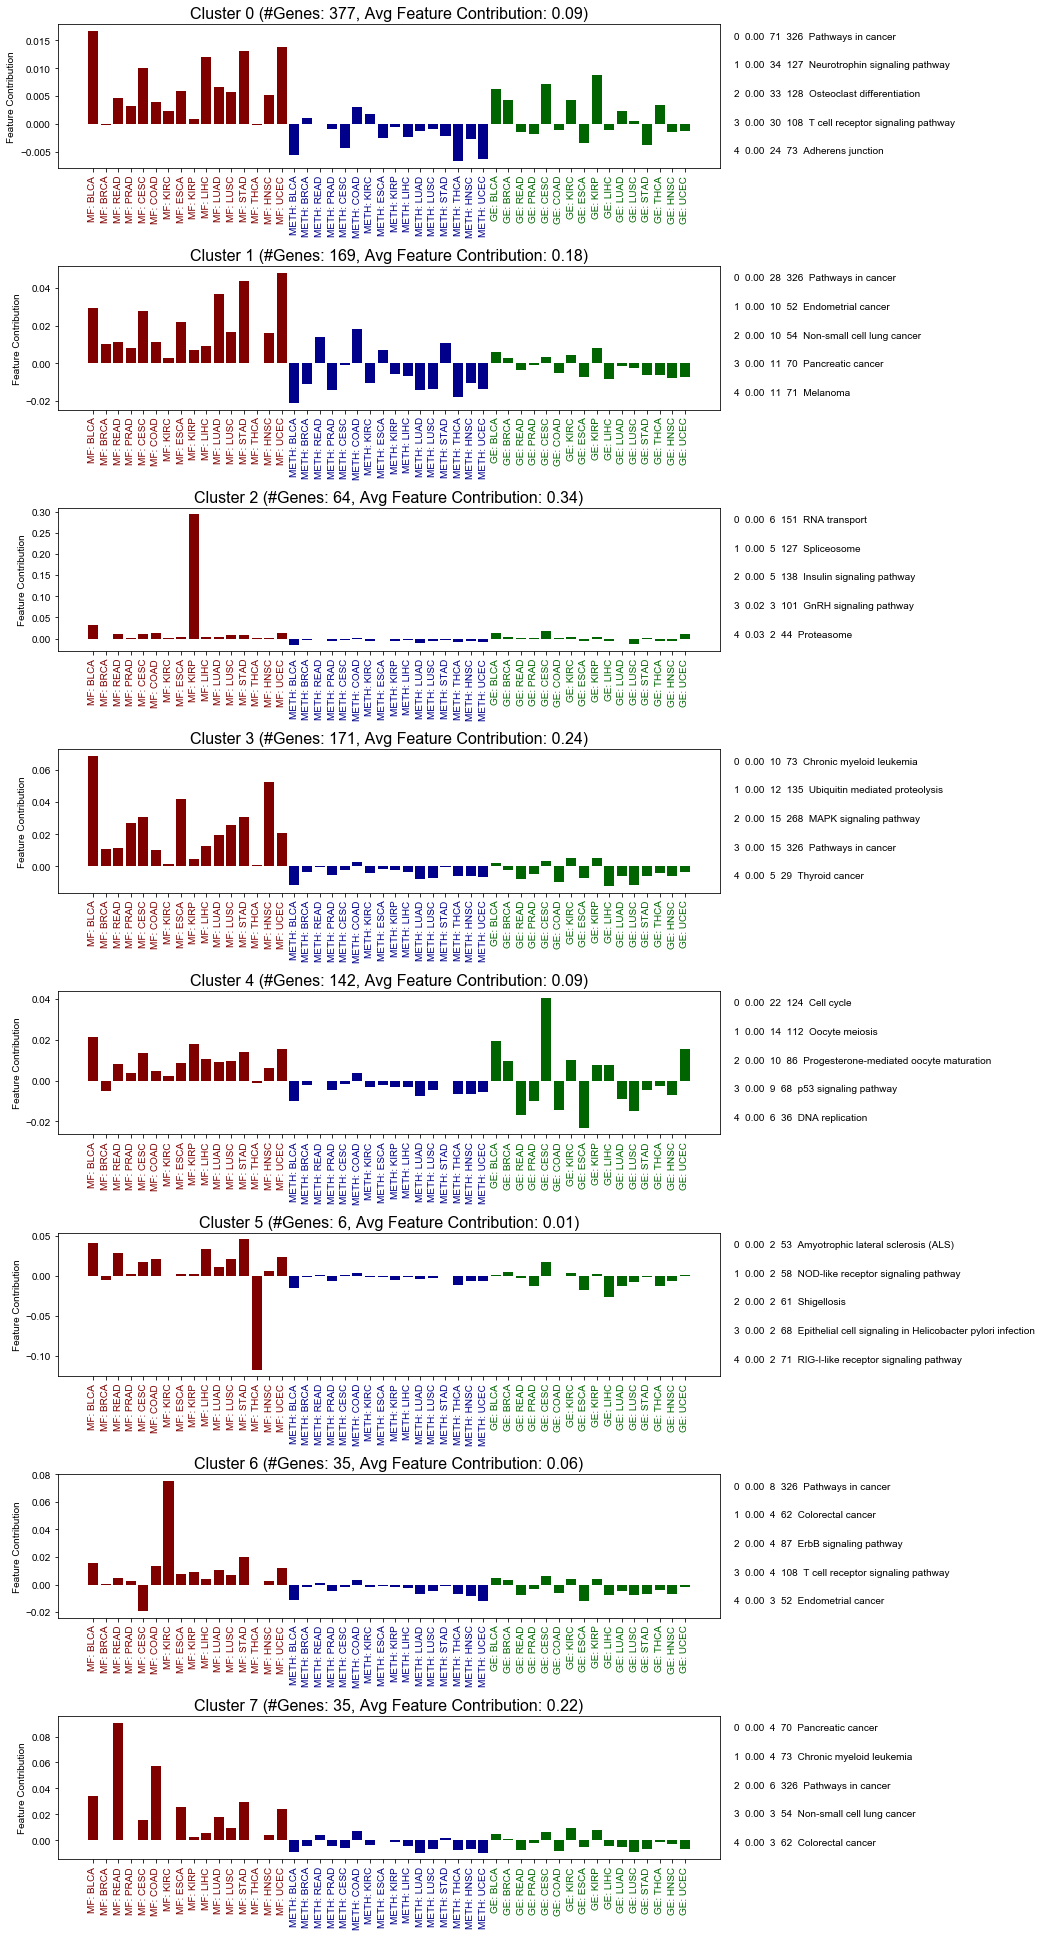

In [81]:
sum_of_all = 0
n_clusters = flat_clusters_series.nunique()
fig, axes = plt.subplots(nrows=n_clusters, ncols=2,
                         figsize=(15, n_clusters*3 + 3),
                         gridspec_kw={'width_ratios': [3, 1]}
                        )

def plot_representative_heatmap(ax, rep, xlabels, title=None):
    rep = rep.reshape(16, 3, order='F')
    inner = gridspec.GridSpecFromSubplotSpec(3, 1, hspace=0, subplot_spec=ax)
    omics = ['Mutation', 'Methylation', 'Expression']
    cmaps = [sns.color_palette("Reds"), sns.color_palette("Blues"), sns.color_palette("Greens")]
    vmax = rep.max()
    vmin = rep.min()
    print ("Max and min ", vmax, vmin)
    for c in range(3):
        ax = plt.Subplot(fig, inner[c])
        xticklabels = False
        if c == 2:
            xticklabels = [i.split(':')[1] for i in xlabels[:16]]
        sns.heatmap(rep[:, c].reshape(1, -1), ax=ax, xticklabels=xticklabels,
                    cbar=False, cmap=cmaps[c],
                    cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
                    vmax=vmax, vmin=vmin)
        ax.set_yticklabels([omics[c]], rotation=0, fontsize=10)
        if not title is None and c == 0:
            ax.set_title(title, fontsize=16)
        fig.add_subplot(ax)
    plt.subplots_adjust(bottom=0.05, hspace=0.05, wspace=0)


for cluster_number in flat_clusters_series.unique():
    # find the genes in the current cluster
    cluster_gene_indices = flat_clusters_series[flat_clusters_series == cluster_number].index
    cluster_genes = nodes[nodes.Name.isin(high_feat_contrib.iloc[cluster_gene_indices].index)]
    
    # compute the representative for that cluster
    features_of_cluster = high_feat_contrib.iloc[cluster_gene_indices]
    representative = features_of_cluster.mean(axis=0)
    representative_std = features_of_cluster.std(axis=0)
    # plot barplot for representative
    plot_representative(axes[cluster_number][0], representative, representative_std, representative.index,
             title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(cluster_number,
                                                                                         cluster_genes.shape[0],
                                                                                         representative.sum()
                                                                                        )
            )
    # plot the pathways next to it
    plot_pathway_information(axes[cluster_number][1], cluster_pathways_highconf[cluster_number][1])
plt.tight_layout()
fig.savefig(os.path.join(model_dir, 'cluster_representatives_highconf_{}.pdf'.format(flat_clusters_series.nunique())))

(48,)
Max and min  0.09082470211599554 0.00022232883077647004
(16, 3)
(1, 3)
(16, 3)
(1, 3)
(16, 3)
(1, 3)


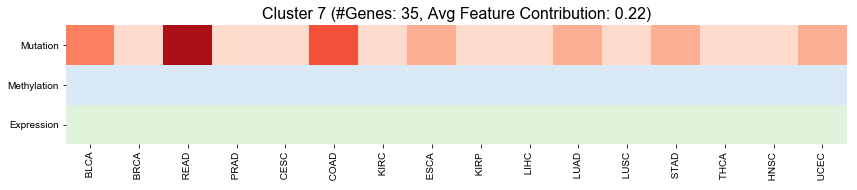

In [138]:
cluster_num = 7
indices = flat_clusters_series[flat_clusters_series == cluster_num].index
contribs = high_feat_contrib.iloc[indices]
rep = contribs.mean(axis=0)

fig = plt.figure(figsize=(14, 2))
ax = plt.subplot(1, 1, 1)
utils.lrp_heatmap_plot(fig, ax, rep.values, rep.index,
                       title='Cluster {0} (#Genes: {1}, Avg Feature Contribution: {2:.2f})'.format(cluster_num, indices.shape[0], rep.sum())
                      )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.savefig(os.path.join(model_dir, 'cluster_{}_heatmap.svg'.format(cluster_num)))

In [96]:
gene_name = 'COIL'

cluster_number = flat_clusters_series[clu.dendrogram_row.reordered_ind.index(nodes[nodes.Name == gene_name].index)]
cluster_gene_indices = flat_clusters_series[flat_clusters_series == cluster_number].index
cluster_genes = nodes[nodes.index.isin(cluster_gene_indices)]
print ("Cluster {} contains {} genes".format(cluster_number, cluster_genes.shape[0]))
#cluster_genes.to_csv(os.path.join(model_dir, 'cluster_{}_gene_{}.tsv'.format(cluster_number, gene_name)), sep='\t')

Cluster 2 contains 3893 genes


In [108]:
start_gene = 'HDC'
end_gene = 'STIM1'
start_idx = clu.dendrogram_row.reordered_ind.index(nodes[nodes.Name == start_gene].index)
end_idx = clu.dendrogram_row.reordered_ind.index(nodes[nodes.Name == end_gene].index)
print (start_idx, end_idx)
relevant_indices = clu.dendrogram_row.reordered_ind[start_idx:end_idx]
relevant_indices
nodes[nodes.index.isin(relevant_indices)].set_index('ID')#.to_csv(os.path.join(model_dir, 'interesting_cluster_{}_{}.tsv'.format(start_gene, end_gene)), sep='\t')

10550 10573


,Name
ID,
ENSG00000162458,FBLIM1
ENSG00000130164,LDLR
ENSG00000086730,LAT2
ENSG00000177971,IMP3
ENSG00000099901,RANBP1
ENSG00000089127,OAS1
ENSG00000181804,SLC9A9
ENSG00000184939,ZFP90
ENSG00000165092,ALDH1A1


## Are Newly Predicted Cancer Genes Interaction or Feature Driven?

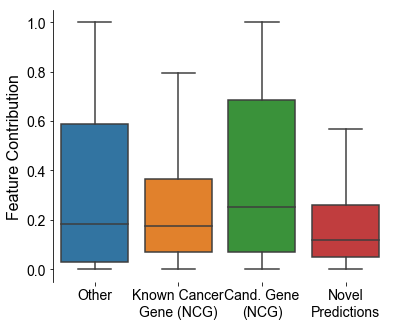

In [15]:
npcgs = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
oncokb, known, candidate = get_cancer_genes()
npcgs.set_index('Name', inplace=True)
contribution_sum_df = pd.DataFrame(feat_contrib_df.sum(axis=1), columns=['Feature_Sum'])
contribution_sum_df['Gene_Set'] = 'Other'
#contribution_sum_df.loc[contribution_sum_df.index.isin(candidate), 'Gene_Set'] = 'Candidate\nCancer Gene'
#contribution_sum_df.loc[contribution_sum_df.index.isin(oncokb['Hugo Symbol']), 'Gene_Set'] = 'OncoKB'
contribution_sum_df.loc[contribution_sum_df.index.isin(known), 'Gene_Set'] = 'Known Cancer\nGene (NCG)'
contribution_sum_df.loc[contribution_sum_df.index.isin(candidate), 'Gene_Set'] = 'Cand. Gene\n(NCG)'
contribution_sum_df.loc[contribution_sum_df.index.isin(npcgs.index), 'Gene_Set'] = 'Novel\nPredictions'
contribution_sum_df.Gene_Set.value_counts()
contribution_sum_df.Feature_Sum = contribution_sum_df.Feature_Sum.abs()
contribution_sum_df.loc[contribution_sum_df.Feature_Sum > 1, 'Feature_Sum'] = 1

fig = plt.figure(figsize=(6, 5))
sns.boxplot(data=contribution_sum_df, x='Gene_Set', y='Feature_Sum', showfliers=False, 
            order=['Other', 'Known Cancer\nGene (NCG)', 'Cand. Gene\n(NCG)', 'Novel\nPredictions'])
plt.ylabel('Feature Contribution', fontsize=16)
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(axis='both', labelsize=14)
fig.savefig(os.path.join(model_dir, 'feature_contribution_npcgs.svg'))

## Dimensionality Reduction

In [3]:
embedding = umap.UMAP(n_components=2).fit_transform(feature_contributions)

In [4]:
from sklearn import cluster

clustering_algo = cluster.DBSCAN(eps=.3)
clustering_algo.fit(feature_contributions)

if hasattr(clustering_algo, 'labels_'):
    y_pred = clustering_algo.labels_.astype(np.int)
else:
    y_pred = clustering_algo.predict(X)

pd.value_counts(y_pred)

 0    8159
-1    3970
dtype: int64

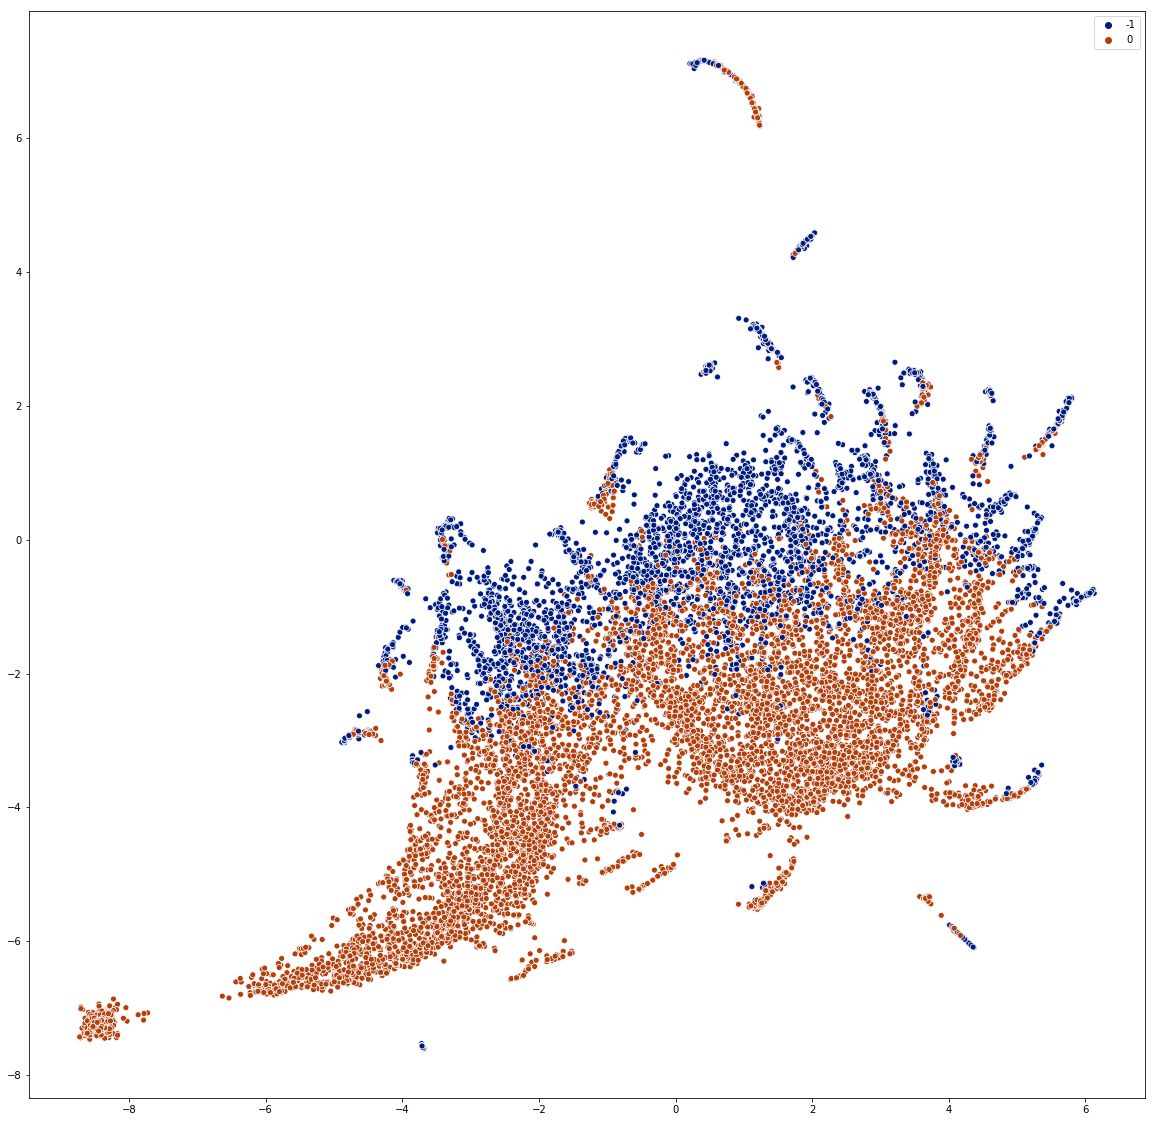

In [6]:
fig = plt.figure(figsize=(20, 20))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y_pred, palette=sns.color_palette("dark", 2))

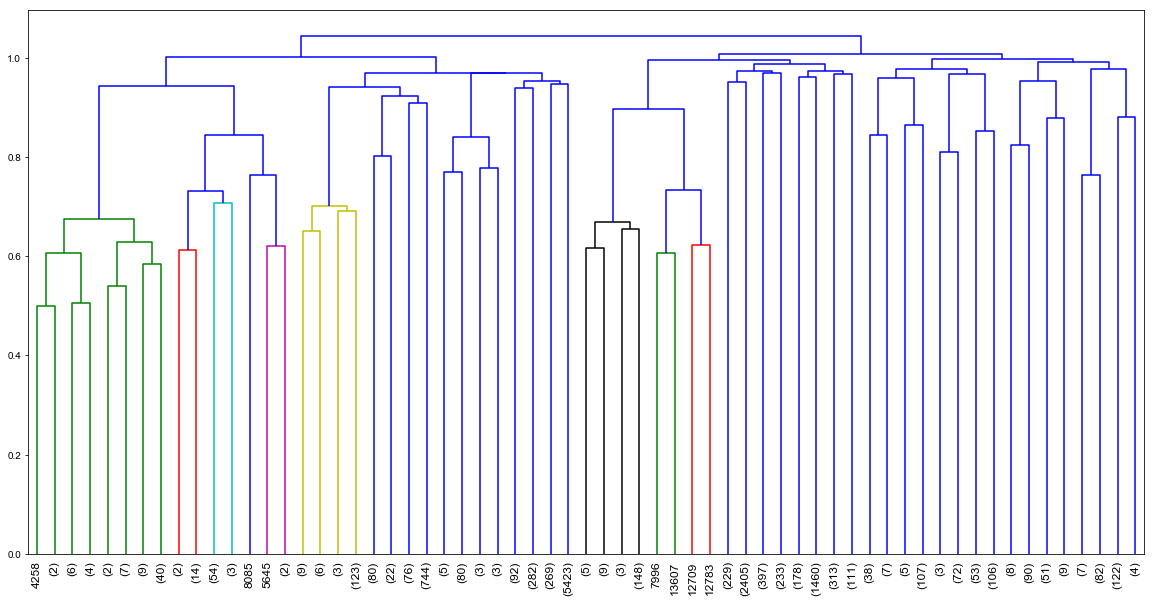

In [27]:
fig = plt.figure(figsize=(20, 10))
H = hierarchy.dendrogram(
    Z,
    truncate_mode='level',
    p=5,  # show only the last p merged clusters
    #show_leaf_counts=True,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=False,  # to get a distribution impression in truncated branches
)
#plt.savefig('test.svg')

In [137]:
clusters = hierarchy.cut_tree(clu.dendrogram_row.linkage, n_clusters=10)

In [140]:
pd.Series(clusters.reshape(-1)).value_counts()

1    7157
0    2793
2    1977
8     369
3     227
5     207
4     188
6     168
7     162
9     143
dtype: int64

## Neighbor Contribution

In [22]:
lrp_neighbor_matrix = np.load(os.path.join(model_dir, 'lrp_sigmoid', 'support_0_mean_sum.npy'))
count = 1
for i in range(5):
    p = os.path.join(model_dir, 'lrp_sigmoid', 'support_{}_mean_sum.npy'.format(i))
    if os.path.isfile(p):
        lrp_neighbor_matrix += np.load(p)
        count += 1
        print ("Loaded and added neighbor contributions with support {}".format(i))
lrp_neighbor_matrix = lrp_neighbor_matrix / float(count)
lrp_neighbor_matrix.min(), lrp_neighbor_matrix.max()

Loaded and added neighbor contributions with support 0
Loaded and added neighbor contributions with support 1


(-1133.4231487286886, 605.889359749145)

In [34]:
min_edge_weight = 1.0

nw_thr = np.where(np.abs(lrp_neighbor_matrix) <= min_edge_weight, 0, lrp_neighbor_matrix)
nw_thr.nonzero()[0].shape, lrp_neighbor_matrix.nonzero()[0].shape

((9907,), (517996,))

In [35]:
nw_thr_df = pd.DataFrame(data=nw_thr, index=node_names[:, 1], columns=node_names[:, 1])
G = nx.from_pandas_adjacency(nw_thr_df, create_using=nx.MultiDiGraph)
nx.set_node_attributes(G=G, values=pred.set_index('Name')['Prob_pos'].to_dict(), name='OutputProb')
print ([len(c) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True) if len(c) > 1])
print (len(max(nx.strongly_connected_components(G), key=len)))
nodes_component = list(max(nx.strongly_connected_components(G), key=len))
x = pd.DataFrame(nodes_component, columns=['Name'])
all_components = [list(c) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True) if len(c) > 1]

[24, 13, 13, 8, 7, 6, 6, 6, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
24


In [36]:
fname = os.path.join(model_dir, 'lrp_neighbors_strongest_comp_{}.gml'.format(min_edge_weight))
nx.write_gml(G.subgraph(nodes_component), path=fname)
print ("Graph written to: {}".format(fname))

Graph written to: ../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/lrp_neighbors_strongest_comp_1.0.gml


In [37]:
node_names_df = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
node_names_df[node_names_df.Name.isin(all_components[0])].to_csv(os.path.join(model_dir, 'strongest_component_nodes.csv'), sep='\t')

In [38]:
nx.write_gml(G.subgraph(all_components[1]), path=os.path.join(model_dir, 'lrp_neighbors_secondlargest_comp_{}.gml'.format(min_edge_weight)))

In [39]:
lrp_neighbor_matrix[node_names_df.Name == 'TP53'].sum()

0.6601897810563809

## Hierarchical HotNet Clustering of Neighbor LRP

In [17]:
lrp_neighbor_df = pd.DataFrame(data=lrp_neighbor_matrix, index=node_names[:, 1], columns=node_names[:, 1])
G = nx.from_pandas_adjacency(lrp_neighbor_df, create_using=nx.MultiDiGraph)

In [33]:
oncokb, known, candidate = get_cancer_genes()
hhnet_clusters, hhgenes = get_hhotnet_results()

for cluster in hhnet_clusters:
    num_cgc_genes = cgc_genes[cgc_genes.index.isin(cluster)].shape[0]
    num_oncokb_genes = oncokb[oncokb['Hugo Symbol'].isin(cluster)].shape[0]
    num_ncg_known = len([i for i in cluster if i in known])
    num_ncg_cand = len([i for i in cluster if i in candidate])
    print (num_cgc_genes, num_oncokb_genes, num_ncg_known, num_ncg_cand)

0 0 0 2
0 0 0 1
0 0 0 2
0 0 0 0
0 0 0 0
0 1 0 1
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 1
1 0 0 0
0 0 0 0
0 0 0 1
0 0 0 0
1 1 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 1
0 0 0 0
0 0 0 0
0 0 0 0
1 1 1 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 1
0 0 0 0
0 0 0 1
1 1 1 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
1 1 1 0
0 0 0 0
0 0 0 1
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0


In [20]:
count = 1
for cluster in hhnet_clusters:
    nx.write_gml(G.subgraph(cluster), path=os.path.join(model_dir, 'hhnet_cluster_{}.gml'.format(count)))
    count += 1

## Using a tool for KEGG pathway enrichment

In [38]:
import mygene

def get_entrez_from_ensembl(list_of_ensembl_ids):
    """Get the entrez gene ID from a list of Ensembl IDs using mygene.

    This function retrieves entrez gene IDs from Ensembl IDs using
    the mygene python API. It requires a stable internet connection to
    retrieve the annotations.

    Parameters:
    ----------
    list_of_ensembl_ids:        A list of strings containing the
                                Ensembl IDs
    
    Returns:
    A dataframe containing the mapping between entrez and ensembl IDs.
    If no symbol could be found for an ID, NA is returned in that row.
    The index of the dataframe are the ensembl IDs and the symbols are
    in the other column.
    """
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_ensembl_ids,
                       scopes='ensembl.gene',
                       fields='entrezgene',
                       species='human', returnall=True
                      )

    def get_entrez_and_ensembl(d):
        if 'entrezgene' in d:
            return [d['query'], d['entrezgene']]
        else:
            return [d['query'], None]

    mapping = [get_entrez_and_ensembl(d) for d in res['out']]
    # now, retrieve the names and IDs from a dictionary and put in DF
    mapping = pd.DataFrame(mapping, columns=['Ensembl_ID', 'Entrezgene']).set_index('Ensembl_ID')
    mapping.dropna(axis=0, inplace=True)
    return mapping

KGID = sp.geneIDconv.geneIDconv(species='hsa')
gene_set = [KGID[entrez_id] for entrez_id in get_entrez_from_ensembl(cluster_genes.ID).Entrezgene]
kegg_pathways = sp.parse_kegg.Request('link', 'path', 'hsa')
pwid2name = sp.parse_kegg.Request('list', 'pathway', 'hsa')
pathways, pathwaycount, pathway_matrix = sp.linkpath2mat.linkpath2mat(gene_set, kegg_pathways)
len(pathways), len(pathwaycount), len(pathway_matrix)
gene_matrix = np.ones((len(gene_set), 1))
enrichment = sp.enrichment.enrichment(gene_matrix, pathway_matrix)
result = sp.out2html.out2html(gene_matrix, pathway_matrix, enrichment, gene_set, pathways, [gene_set], pathwaycount, 0.01, 'test.html', pwid2name)